In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime 

import sys
sys.path.append('..')

from utils import *
from config import *
from data_config import *
import config
import logging

# Workflow

1. Identify admitted OUD patients
2. Only OUD, and other SUD patients
3. Create lists for SUD patients
4. Create a list of patients without sud
5. Get immunization information

# Extract OUD patients 

In [2]:
diagnosis_path = os.path.join(COVID_MERGED_DATA_PATH, 'diagnosis.csv')
diagnosis_copy = load_data(diagnosis_path)

In [3]:
diagnosis = diagnosis_copy.copy()
diagnosis = diagnosis[diagnosis['enc_type'].isin(admission_enc_type_list)]
diag_filtered = diagnosis[diagnosis_columns].astype(str)
unique_patients = diag_filtered['patient_num'].unique()
# This is also including the patients who have no diagnosis code of covid
print('There are {} unique patients in the COVID-19 data set (2020-2023).'.format(len(unique_patients)))


There are 47978 unique patients in the COVID-19 data set (2020-2023).


## Create a dictionary to store patients with SUDs

In [4]:
# Filter patients based on ICD-10 codes and calculate the counts
disorder_counts = {}
patient_ids_disorder = {}
diag_df_disorder = {}

# Iterate through the dictionary of disorders and codes
for disorder, codes in SUD_ICD_CODE.items():
    # disorder_name = disorder.split(' ')[0]
    logging.info('Filtering the patients with {} ...'.format(disorder))
    filtered_df = diag_filtered[diag_filtered['dx_code'].str.contains('|'.join(codes))]
    filtered_df.drop_duplicates(subset=['patient_num', 'encounter_num'], inplace=True)
    
    # Store dataframes to dictionary
    diag_df_disorder[disorder] = filtered_df
    print('Saving the patient ids by {} disorder to .csv ...'.format(disorder))
    save_processed_data(filtered_df,  disorder, path=PROCESSED_DATA_PATH)
    
    # # Store patient ids to dictionary
    ids = set(filtered_df['patient_num'].tolist())
    patient_ids_disorder[disorder] = ids
    # Store patient ids to txt file
    logging.info('Saving the patient ids by disorder to .txt ...')
    with open(os.path.join(PROCESSED_DATA_PATH, disorder, disorder + '.txt'), 'w') as f:
        for id in ids:
            f.write(str(id) + '\n')
    disorder_counts[disorder] = len(ids)

/tmp/ipykernel_61470/44373102.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop_duplicates(subset=['patient_num', 'encounter_num'], inplace=True)


Saving the patient ids by Alcohol Use Disorder disorder to .csv ...
Saving the patient ids by Cannabis Use Disorder disorder to .csv ...
Saving the patient ids by Cocaine Use Disorder disorder to .csv ...
Saving the patient ids by Opioid Use Disorder disorder to .csv ...
Saving the patient ids by Tobacco Use Disorder disorder to .csv ...


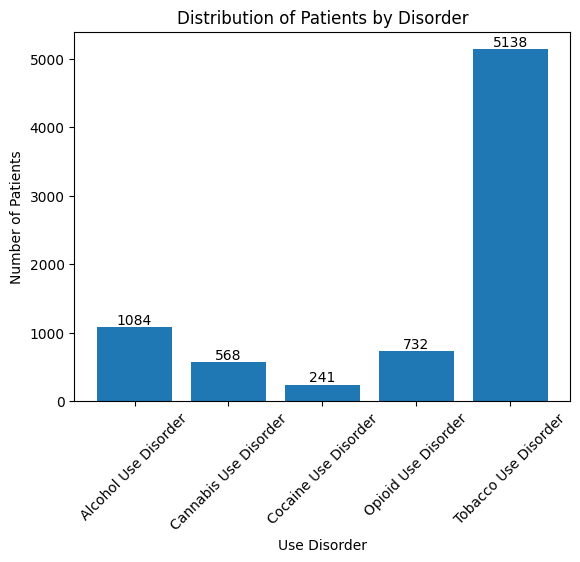

In [5]:
# Plot the bar chart
plt.bar(disorder_counts.keys(), disorder_counts.values())
plt.xlabel('Use Disorder')
plt.ylabel('Number of Patients')
plt.title('Distribution of Patients by Disorder')
plt.xticks(rotation=45)

# Print numbers of disorder above the bar
for i, count in enumerate(disorder_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.savefig(os.path.join(RESULTS, 'Distribution of Patients by Disorder.png'), bbox_inches='tight')
plt.show()

In [6]:
# concatenate all patient ids in patient_ids_disorder dictionary
patient_ids = []
for ids in patient_ids_disorder.values():
    patient_ids += ids
patient_ids = list(set(patient_ids))
print('There are {} unique patients with use disorder in the COVID-19 data set (2020-2023).'.format(len(patient_ids)))

# Exclude patients in patient_ids in the disagnosis table
diag_df_without_disorder = diag_filtered[~diag_filtered['patient_num'].isin(patient_ids)]
patient_ids_without_disorder = set(diag_df_without_disorder['patient_num'].tolist())
print('There are {} unique patients without use disorder in the COVID-19 data set (2020-2023).'.format(len(patient_ids_without_disorder)))

There are 6416 unique patients with use disorder in the COVID-19 data set (2020-2023).
There are 41562 unique patients without use disorder in the COVID-19 data set (2020-2023).


# Filter admitted patients using diagnosis and encounter tables
(From Merged Data)

In [7]:
encounters_path = os.path.join(COVID_MERGED_DATA_PATH, 'encounters.csv')
encounters_copy = load_data(encounters_path)

In [8]:
encounters = encounters_copy.copy()
l=['IP','ED','UN','OS']
encounters = encounters[encounters['enc_type'].isin(l)]
enc_filtered = encounters[encounters_columns].astype(str)
enc_filtered.shape

(191036, 9)

In [9]:
diag_enc_merge = diag_filtered.merge(enc_filtered, on=['patient_num', 'encounter_num'], how='left')
diag_enc_merge = diag_enc_merge[diag_enc_merge['admit_date_shifted'].notnull()]
diag_enc_merge = diag_enc_merge[diag_enc_merge['discharge_status_c'] != 'nan']
diag_enc_merge = diag_enc_merge.sort_values(by=['patient_num', 'dx_date_shifted'], ascending=True)

In [10]:

# group by patient_num and encounter_num amd create a new column named 'dx_code_list'
# drop duplicates of patient_num and encounter_num
diag_enc_merge['dx_code_list'] = diag_enc_merge.groupby(['patient_num', 'encounter_num'])['dx_code'].transform(lambda x: ', '.join(x))
diag_enc_merge['dx_code_list'] = diag_enc_merge['dx_code_list'].apply(lambda x: list(set(x.split(', '))))
diag_enc_merge = diag_enc_merge.drop_duplicates(subset=['patient_num', 'encounter_num'])


In [11]:
# save dx_code_list to csv
save_processed_data(diag_enc_merge[['patient_num', 'encounter_num', 'dx_code_list']], 'dx_code_list', path=PROCESSED_DATA_PATH)
diag_enc_merge.drop(['dx_code'], axis=1, inplace=True)

In [12]:
# Change the data type of 'xxx_date_shift' to datetime
diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted'])
diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted'])
diag_enc_merge['discharge_date_shifted'] = pd.to_datetime(diag_enc_merge['discharge_date_shifted'])

# Drop the rows where 'dx_date_shifted' before date 2020-03-01
diag_enc_merge = diag_enc_merge[diag_enc_merge['dx_date_shifted'] > datetime.datetime(2020, 3, 1)]


In [13]:
# Change the data type of 'xxx_date_shift' to datetime
diag_enc_merge['dx_date_shifted'] = pd.to_datetime(diag_enc_merge['dx_date_shifted']).dt.date
diag_enc_merge['admit_date_shifted'] = pd.to_datetime(diag_enc_merge['admit_date_shifted']).dt.date
diag_enc_merge['discharge_date_shifted'] = pd.to_datetime(diag_enc_merge['discharge_date_shifted']).dt.date


In [14]:
diag_enc_merge

,patient_num,encounter_num,dx_date_shifted,age_at_visit_years,discharge_status_c,department_name,payor_type_primary_name,admit_date_shifted,discharge_date_shifted,length_of_stay_days,dx_code_list
3314675,16777551,230789668,2021-08-18,66,HO,FH EMERGENCY DEPT,MEDICARE,2021-08-18,2021-08-18,1.0,"[E78.2, R26.81, Z01.89, S90.411A, I12.9, R06.0..."
3314299,16777551,172656352,2022-09-15,67,HO,FH OUTPATIENT CARE CTR,MEDICARE,2022-09-15,2022-09-16,1.0,"[D62, E78.5, I25.10, Z23, N17.9, Z01.89, K62.5..."
150516,16777685,144353253,2020-12-21,65,HO,CMH MODIFIED CARE UNIT,Managed Care (Private),2020-12-21,2020-12-25,4.0,"[Z71.3, K70.31, R18.8, Z23, E87.1, N43.3, R64,..."
153325,16777685,171297129,2020-12-27,65,HO,CMH SURGICAL INPT,Managed Care (Private),2020-12-27,2021-01-04,8.0,"[K70.31, E87.1, Z86.19, R79.1, K74.60, K70.40,..."
2870041,16778374,136581620,2022-07-13,32,HO,FH 7EP,Managed Care (Private),2022-07-13,2022-07-16,3.0,"[O75.89, Z34.03, O69.0XX1, Z3A.37, Z86.16, Z01..."
...,...,...,...,...,...,...,...,...,...,...,...
2464575,68041912,73930869,2022-01-07,20,HO,FH EMERGENCY DEPT,Medicaid HMO,2022-01-07,2022-01-07,1.0,"[R51.9, U07.1, Z01.89, M79.18, R50.9, Z32.02, ..."
2464221,70484423,154743825,2022-10-14,22,HO,DTSHC URGENT CARE,Managed Care (Private),2022-10-14,2022-10-14,1.0,[R39.9]
2465561,70484423,254680619,2022-10-14,22,HO,FCHO EMERGENCY DEPT,Managed Care (Private),2022-10-14,2022-10-15,1.0,"[N30.01, T88.7XXA, R11.0, R21, R68.83, Z20.822]"
2901749,73671308,316066435,2022-01-08,30,HO,DTSHC URGENT CARE,Managed Care (Private),2022-01-08,2022-01-08,1.0,"[S06.0X0A, R51.9, M25.511]"


In [15]:
save_processed_data(diag_enc_merge, 'diag_enc_merge_original')

## Filter mortality and non-mortality patients 

In [16]:
diag_enc_merge_no_mortality = diag_enc_merge[diag_enc_merge['discharge_status_c'] != 'EX']
diag_enc_merge_mortality = diag_enc_merge[diag_enc_merge['discharge_status_c'] == 'EX']
diag_enc_merge_no_mortality.drop(['discharge_status_c', 'length_of_stay_days'], axis=1, inplace=True)
diag_enc_merge_mortality.drop(['discharge_status_c', 'length_of_stay_days'], axis=1, inplace=True)



/tmp/ipykernel_61470/813238103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_enc_merge_no_mortality.drop(['discharge_status_c', 'length_of_stay_days'], axis=1, inplace=True)
/tmp/ipykernel_61470/813238103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_enc_merge_mortality.drop(['discharge_status_c', 'length_of_stay_days'], axis=1, inplace=True)


### Remove dead patients from "mortality"

In [17]:
diag_enc_merge_no_mortality['patient_num'].nunique()

39487

In [18]:
# Remove dead patients from "mortality"
dead_patients = set(diag_enc_merge_mortality['patient_num'].tolist())
diag_enc_merge_no_mortality = diag_enc_merge_no_mortality[~diag_enc_merge_no_mortality['patient_num'].isin(dead_patients)]

In [19]:
print(diag_enc_merge_no_mortality['patient_num'].nunique())
print(diag_enc_merge_mortality['patient_num'].nunique())

38958
930


In [20]:
save_processed_data(diag_enc_merge_no_mortality, 'diag_enc_merge_no_mortality', path=PROCESSED_DATA_PATH)
save_processed_data(diag_enc_merge_mortality, 'diag_enc_merge_mortality', path=PROCESSED_DATA_PATH)

## Re-calculate hospitalization

In [35]:
diag_enc_merge_no_mortality = load_processed_data('diag_enc_merge_no_mortality', path=PROCESSED_DATA_PATH)
diag_enc_merge_mortality = load_processed_data('diag_enc_merge_mortality', path=PROCESSED_DATA_PATH)

In [36]:
diag_enc_merge_no_mortality['dx_date_shifted'] = pd.to_datetime(diag_enc_merge_no_mortality['dx_date_shifted'])
diag_enc_merge_no_mortality['admit_date_shifted'] = pd.to_datetime(diag_enc_merge_no_mortality['admit_date_shifted'])
diag_enc_merge_no_mortality['discharge_date_shifted'] = pd.to_datetime(diag_enc_merge_no_mortality['discharge_date_shifted'])

In [49]:
diag_enc_merge_los = diag_enc_merge_no_mortality.copy()
diag_enc_merge_los.dropna(subset=['admit_date_shifted'], inplace=True)
diag_enc_merge_los.dropna(subset=['discharge_date_shifted'], inplace=True)
diag_enc_merge_los.sort_values(["patient_num", "admit_date_shifted"], inplace=True)


In [50]:
print(diag_enc_merge_los['admit_date_shifted'].isnull().sum())
print(diag_enc_merge_los['discharge_date_shifted'].isnull().sum())


0
0


In [53]:
def count_los(df):
    # Initialize output data
    output_data = []

    # Iterate over unique patients
    for patient in df['patient_num'].unique():
        # Get all records for this patient
        patient_data = df[df['patient_num'] == patient]

        # Initialize admission_data variable to hold the ongoing admission data
        admission_data = None

        # Iterate over records for this patient
        for idx, row in patient_data.iterrows():
            if admission_data is None:
                # If this is the first row, start a new admission
                admission_data = row.to_dict()
                admission_data['encounter_list'] = [admission_data['encounter_num']]
                continue

            # Check if this row's admit_date is before or at the previous discharge_date
            if row['admit_date_shifted'] <= admission_data['discharge_date_shifted']:
                # If yes, update the discharge_date and add the encounter to the list
                admission_data['discharge_date_shifted'] = max(admission_data['discharge_date_shifted'], row['discharge_date_shifted'])
                admission_data['encounter_list'].append(row['encounter_num'])
            else:
                # If no, this is a new admission
                # First, calculate the length of stay of the previous admission and add it to the output
                admission_data['total_length_of_stay'] = (admission_data['discharge_date_shifted'] - admission_data['admit_date_shifted']).days + 1
                output_data.append(admission_data)

                # Then, start a new admission with this row
                admission_data = row.to_dict()
                admission_data['encounter_list'] = [admission_data['encounter_num']]

        # At the end of the patient's records, add the last admission
        admission_data['total_length_of_stay'] = (admission_data['discharge_date_shifted'] - admission_data['admit_date_shifted']).days + 1
        output_data.append(admission_data)

    # Convert the output data to a DataFrame
    patient_df = pd.DataFrame(output_data)
    return patient_df


In [52]:
print('Processing non-mortality data ...')
result = count_los(diag_enc_merge_los)
save_processed_data(result, 'diag_enc_merge_covid_no_mortality_recalculate')

Processing non-mortality data ...


In [54]:
result['total_length_of_stay'].isnull().sum()


0

# Process Immunization Data

In [55]:
# Read immunization.csv
immunization_path = os.path.join(COVID_MERGED_DATA_PATH, 'immunization.csv')
immunization_df_copy = load_data(immunization_path)
immunization_df_copy.shape

(225457, 28)

In [56]:
immu_df = immunization_df_copy.copy()
immu_df = immu_df[immu_df['immnztn_status_name'] == 'Given']
immu_df = immu_df[immu_df['immunization_name'].str.contains('|'.join(immunization_name), na=False, case=False)]
immu_df = immu_df[immu_df['immune_date_shifted'].notnull()]
immu_df = immu_df.drop_duplicates(subset=['patient_num', 'encounter_num'], keep='first')

In [57]:
immu_df = immu_df[immunization_columns].astype(str)
immu_df['immune_date_shifted'] = pd.to_datetime(immu_df['immune_date_shifted'], format='%Y-%m-%d %H:%M:%S').dt.date

In [58]:
def set_mfg(x: str):
    if 'PFIZER' in x:
        return 'PFIZER'
    elif 'MODERNA' in x:
        return 'MODERNA'
    elif 'JANSSEN' in x:
        return 'JANSSEN'
    else:
        return 'Others'
immu_df['immu_mfg'] = immu_df['immunization_name'].apply(set_mfg)
immu_df = immu_df.drop(columns=['immunization_name']).sort_values(by=['patient_num', 'immune_date_shifted'])

In [59]:
save_processed_data(immu_df, 'immu_df_covid')

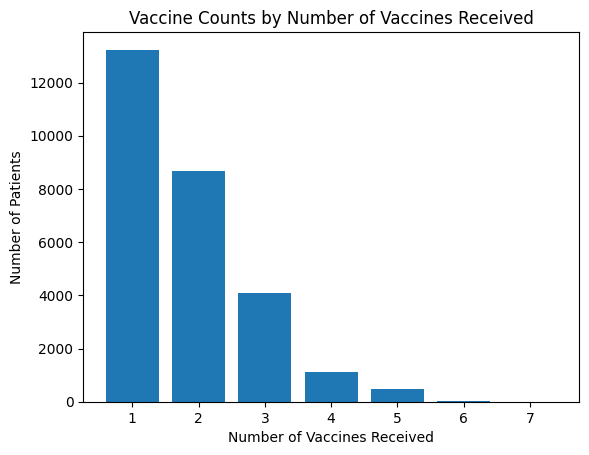

In [60]:
# Count the number of vaccines received by each patient
vaccine_counts = immu_df.groupby('patient_num').size().reset_index(name='count')

# Count the patients receiving 1, 2, 3, or more vaccines
count_summary = vaccine_counts['count'].value_counts().sort_index()

# Plot the bar chart
plt.bar(count_summary.index, count_summary.values)

# Add labels and title
plt.xlabel('Number of Vaccines Received')
plt.ylabel('Number of Patients')
plt.title('Vaccine Counts by Number of Vaccines Received')

# Display the chart
plt.savefig(os.path.join(RESULTS, 'Vaccine Counts.png'), bbox_inches='tight')
plt.show()

## Get patients with full vaccination

In [61]:
def get_vaccine_fulfillment_date(group):
    group = group.sort_values('immune_date_shifted')
    if any(group['immu_mfg'] == 'JANSSEN'):
        return group.loc[group['immu_mfg'] == 'JANSSEN', 'immune_date_shifted'].iloc[0]
    else:
        if group['immu_mfg'].isin(['MODERNA', 'PFIZER']).sum() >= 2:
            return group.loc[group['immu_mfg'].isin(['MODERNA', 'PFIZER']), 'immune_date_shifted'].iloc[1]
    return pd.NaT

immu_df['immune_date_shifted'] = pd.to_datetime(immu_df['immune_date_shifted'])
df_sorted = immu_df.sort_values(['patient_num', 'immune_date_shifted'])
fulfillment_dates = df_sorted.groupby('patient_num').apply(get_vaccine_fulfillment_date).dropna().reset_index()
fulfillment_dates.columns = ['patient_num', 'date_of_full_vaccination']

In [62]:
fulfillment_dates

,patient_num,date_of_full_vaccination
0,16777551,2022-05-17
1,16780070,2021-02-18
2,16780383,2021-04-23
3,16783637,2021-05-11
4,16786746,2021-07-18
...,...,...
15012,64230623,2022-01-09
15013,64243286,2022-06-11
15014,64417668,2021-03-04
15015,66746840,2021-04-20


In [30]:
save_processed_data(fulfillment_dates, 'full_vaccination_df_covid')